In [8]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim

In [9]:
# Define the COCO dataset class
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        image_info = coco.loadImgs(img_id)[0]
        path = image_info['file_name']

        img = cv2.imread(os.path.join(self.image_dir, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        if boxes.size(0) > 0:  # Check if there are any boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [10]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = 'university_landmark/train/_annotations.coco.json'
image_dir = 'university_landmark/train/train_images'
dataset = COCODataset(annotation_file, image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


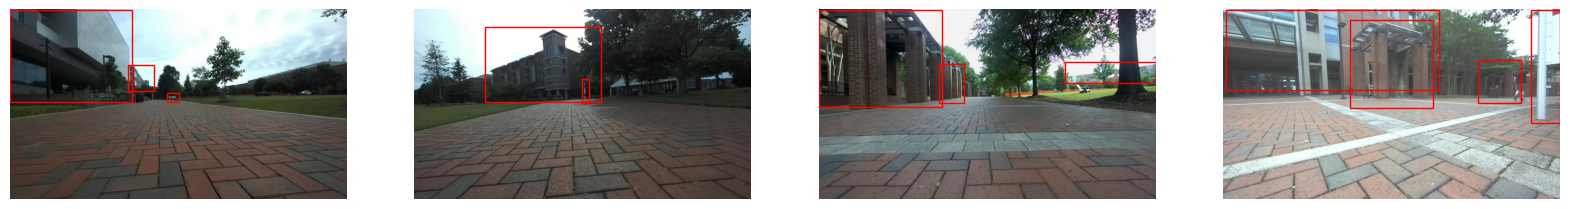

In [11]:
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

In [12]:
# Load a pre-trained model for classification and return only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
num_epochs = 10
learning_rate = 0.005
model_save_path = "model.pt"
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Iteration: {i}, Loss: {losses.item():.4f}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")
    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")

# Save the final model
torch.save(model.state_dict(), model_save_path)
print("Training complete. Model saved.")
print("Training complete.")


Starting epoch 1/10
Epoch: 1/10, Iteration: 0, Loss: 2.3461
Epoch: 1/10, Iteration: 10, Loss: 0.5012
Epoch: 1/10, Iteration: 20, Loss: 0.4561
Epoch: 1/10, Iteration: 30, Loss: 0.5076
Epoch: 1/10, Iteration: 40, Loss: 0.8738
Epoch: 1/10, Iteration: 50, Loss: 0.4064
Epoch: 1/10, Iteration: 60, Loss: 0.2570
Epoch: 1/10, Iteration: 70, Loss: 0.4176
Epoch: 1/10, Iteration: 80, Loss: 0.4653
Epoch: 1/10, Iteration: 90, Loss: 0.2404
Epoch: 1/10, Iteration: 100, Loss: 0.3397
Epoch: 1/10, Iteration: 110, Loss: 0.3552
Epoch: 1/10, Iteration: 120, Loss: 0.4113
Epoch: 1/10, Iteration: 130, Loss: 0.3151
Epoch: 1/10, Iteration: 140, Loss: 0.1910
Epoch: 1/10, Iteration: 150, Loss: 0.2316
Epoch: 1/10, Iteration: 160, Loss: 0.3068
Epoch: 1/10, Iteration: 170, Loss: 0.5530
Epoch: 1/10, Iteration: 180, Loss: 0.5858
Epoch: 1/10, Iteration: 190, Loss: 0.3357
Epoch: 1/10, Iteration: 200, Loss: 0.2668
Epoch: 1/10, Iteration: 210, Loss: 0.3764
Epoch: 1/10, Iteration: 220, Loss: 0.2084
Epoch: 1/10, Iteration: 2

In [14]:
# Load the model 
model.load_state_dict(torch.load(model_save_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

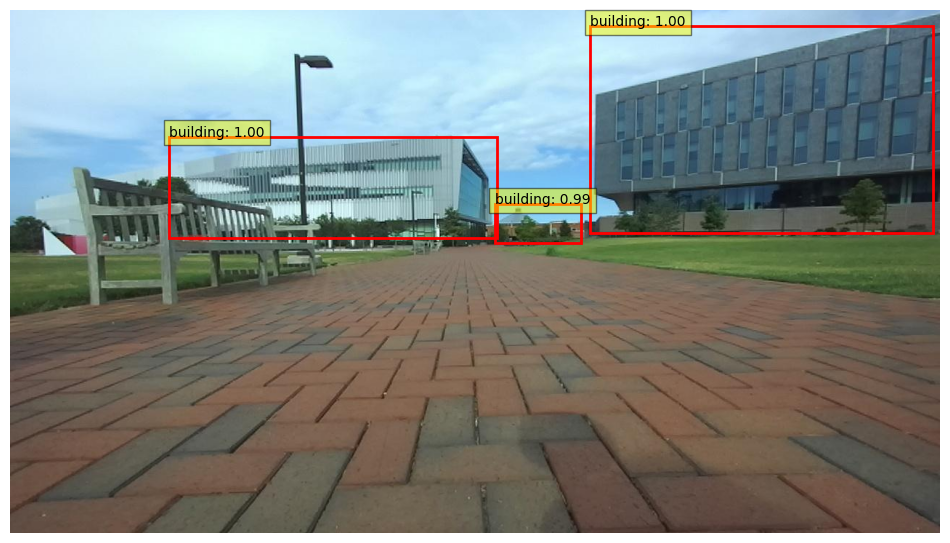

In [17]:
from PIL import Image
import matplotlib.patches as patches  # Ensure patches is imported
# Define the transformation to match the training preprocessing
transform = transforms.Compose([
    # transforms.Resize((320, 240)),  # Resize to (320, 240)
    transforms.ToTensor(),  
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0) 

# Load and preprocess the test image
# test_image_path = '09_52_52.jpg' 
test_image_path = 'university_landmark/test/test_image/2024-07-11-09_46_19_jpg.rf.ea5019f6402163f4972c3c3a1dfd5302.jpg'
test_image = load_image(test_image_path).to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    prediction = model(test_image)

# Define categories as per the COCO dataset
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "building"},
    {"id": 2, "name": "security station"},
    {"id": 3, "name": "sign"},
    {"id": 4, "name": "structure"}
]

# Create a dictionary to map label IDs to category names
label_to_category = {cat['id']: cat['name'] for cat in categories}

def visualize_predictions(image, prediction, threshold=0.5):
    # Convert the tensor image to a NumPy array and transpose the dimensions
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{label_to_category.get(label, "Unknown")}: {score:.2f}', 
                    bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

visualize_predictions(test_image, prediction)